# Statistical Analysis of Topological Indices

## Topological Indices
we use the following indices
- wiener index
- randic index
- generalized randic index
- harmonic index
- atom bond connectivity index
- first zagreb index
- second zagreb index

In [7]:
# we need to read the dataset from the pickle file
import pickle

with open('data/dataset.pickle', 'rb') as f:
    dataset = pickle.load(f)

for key in dataset.keys():
    print(f"datasetkey: {key}, shape: {len(dataset[key])}")

# order the dataset by number of nodes
for key in dataset.keys():
    dataset[key] = sorted(dataset[key], key=lambda x: x.number_of_nodes())


datasetkey: random, shape: 1000
datasetkey: smallworld, shape: 1000
datasetkey: scalefree, shape: 200
datasetkey: complete, shape: 200
datasetkey: line, shape: 200
datasetkey: tree, shape: 400
datasetkey: star, shape: 200


In [8]:
# we use grinpy to calculate the topological indices for each graph
import grinpy as gp
import networkx as nx
from tqdm.notebook import tqdm
from indices import indices


def get_topological_indices(G):
    ''' Create a dictionary with the topological indices of a graph G.'''
    topological_indices = {}
    topological_indices['nodes'] = nx.number_of_nodes(G)
    topological_indices['wiener_index'] = gp.wiener_index(G)
    topological_indices['randic_index'] = gp.randic_index(G)
    topological_indices['generalized_randic_index'] = gp.generalized_randic_index(
        G, 2)
    topological_indices['harmonic_index'] = gp.harmonic_index(G)
    topological_indices['atom_bond_connectivity_index'] = gp.atom_bond_connectivity_index(
        G)
    topological_indices['first_zagreb_index'] = gp.first_zagreb_index(G)
    topological_indices['second_zagreb_index'] = gp.second_zagreb_index(G)
    topological_indices['estrada_index'] = nx.estrada_index(G)
    # topological_indices['balaban_j_index'] = indices.balaban_j_index(G)
    topological_indices['hosoya_z_index'] = indices.hosoya_z_index(G)
    topological_indices['chromatic_information_index'] = indices.chromatic_information_index(
        G)
    topological_indices['szeged_index'] = indices.szeged_index(G)

    return topological_indices


def topological_indices_all_graphs(dataSet, subtypes_to_skip=[]):
    ''' Create a dictionary with the topological indices of all graphs in the dataset.'''
    topological_indices = {}

    for key in tqdm(dataSet.keys(), total=len(dataset.keys()), desc='Calculating TIs for Class'):

        if key in subtypes_to_skip:
            continue

        topological_indices[key] = {}
        l = len(dataSet[key])
        for (i, graph) in tqdm(enumerate(dataSet[key]), total=l, desc=f'Calculating TIs for {key} graphs'):
            topological_indices[key][graph] = get_topological_indices(graph)
    return topological_indices


subtypes_to_skip = []

topological_indices_all_graphs = topological_indices_all_graphs(
    dataset, subtypes_to_skip)

# save the topological indices to a pickle file

with open('data/topological_indices.pickle', 'wb') as f:
    pickle.dump(topological_indices_all_graphs, f)


Calculating TIs for Class:   0%|          | 0/7 [00:00<?, ?it/s]

Calculating TIs for random graphs:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating TIs for smallworld graphs:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating TIs for scalefree graphs:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating TIs for complete graphs:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating TIs for line graphs:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating TIs for tree graphs:   0%|          | 0/400 [00:00<?, ?it/s]

Calculating TIs for star graphs:   0%|          | 0/200 [00:00<?, ?it/s]

In [9]:
# we need to read the dataset from the pickle file
import pickle

with open('data/topological_indices.pickle', 'rb') as f:
    topological_indices_all_graphs = pickle.load(f)

for key in topological_indices_all_graphs.keys():
    print(
        f"topological_indices_all_graphs key: {key}, shape: {len(topological_indices_all_graphs[key])}")


topological_indices_all_graphs key: random, shape: 1000
topological_indices_all_graphs key: smallworld, shape: 1000
topological_indices_all_graphs key: scalefree, shape: 200
topological_indices_all_graphs key: complete, shape: 200
topological_indices_all_graphs key: line, shape: 200
topological_indices_all_graphs key: tree, shape: 400
topological_indices_all_graphs key: star, shape: 200


In [10]:
import pickle
import gc

output = open('data/topological_indices.pickle', 'rb')

# disable garbage collector
gc.disable()

topological_indices_all_graphs = pickle.load(output)

# enable garbage collector again
gc.enable()
output.close()


In [11]:
# now we perform the PCA on the dataset
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import preprocessing
from tqdm.notebook import tqdm

pd.set_option('display.width', 1000)
sns.set()


def topo_numpy_array(topological_indices_subset):
    topo_dataset = []
    for (i, graph_topo) in enumerate(topological_indices_subset):
        graph_ti_dict = topological_indices_subset[graph_topo]
        graph_ti_float_values = np.array(
            list(graph_ti_dict.values()), dtype=float)

        if np.any(np.isinf(graph_ti_float_values)):
            print(f"inf in graph {graph_topo}")
            continue

        topo_dataset.append(np.array(graph_ti_float_values))

    return topo_dataset


def display_correlation(title, df):
    r = df.corr(method="spearman")
    plt.figure(figsize=(10, 6))
    heatmap = sns.heatmap(df.corr(), vmin=-1,
                          vmax=1, annot=True)
    plt.title("Spearman Correlation")
    plt.savefig(f"./../../docs/images/30_results/{title}-correlation.png")
    return (r)


def display_corr_pairs(df, title, color="cyan"):
    s = set_title = np.vectorize(lambda ax, r, rho: ax.title.set_text("r = " +
                                                                      "{:.2f}".format(r) +
                                                                      '\n $\\rho$ = ' +
                                                                      "{:.2f}".format(rho)) if ax != None else None
                                 )

    r = display_correlation(title, df)
    rho = df.corr(method="pearson")
    g = sns.PairGrid(df, corner=True)
    g.map_diag(plt.hist, color="yellow")
    g.map_lower(sns.scatterplot, color="magenta")
    set_title(g.axes, r, rho)
    plt.title(title)
    plt.subplots_adjust(hspace=0.6)
    plt.savefig(
        f"./../../docs/images/30_results/{title}-correlation-pairs.png")
    plt.show()


def plot_pd_frame(dataset, title):
    ''' Plot a pandas dataframe.'''
    plt.figure()
    dataset.plot()
    lgd = plt.legend(bbox_to_anchor=(1.05, 1),
                     loc='upper left', borderaxespad=0.)
    plt.title(title)
    plt.savefig(f"./../../docs/images/30_results/{title}-ti-comparison.png",
                bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()


def print_scree_plot(key, data_scaled):
    pca = PCA(n_components=4)
    # Fit and transform data
    reduced_features = pca.fit(data_scaled)
    PC_values = np.arange(pca.n_components_) + 1

    # Bar plot of explained_variance
    plt.figure()
    plt.plot(PC_values, pca.explained_variance_ratio_,
             'o-', linewidth=2, color='blue')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.savefig(f"./../../docs/images/30_results/{key}-scree.png")
    plt.show()


def print_explained_variance_ratio(key, data_scaled):
    pca = PCA().fit(data_scaled)

    plt.rcParams["figure.figsize"] = (8, 5)

    fig, ax = plt.subplots()
    xi = np.arange(1, 13, step=1)
    y = np.cumsum(pca.explained_variance_ratio_)

    plt.ylim(0.0, 1.1)
    plt.plot(xi, y, marker='o', linestyle='-', color='black')

    plt.xlabel('Number of Components')
    plt.xticks(np.arange(1, 14, step=1))
    plt.ylabel('Cumulative variance (%)')
    plt.title('The number of components needed to explain variance')

    plt.axhline(y=0.95, color='grey', linestyle='--')
    plt.text(1.1, 1, '95% cut-off threshold', color='black', fontsize=16)

    ax.grid(axis='x')
    plt.tight_layout()
    plt.savefig(f"./../../docs/images/30_results/{key}-scree-cum.png")
    plt.show()


def print_2d_pca_graph(key, data_scaled, data_unscaled):
    pca = PCA(n_components=2)
    components = pca.fit_transform(data_scaled)

    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

    fig = px.scatter(components, x=0, y=1, color=data_unscaled['nodes'])

    for i, feature in enumerate(data_scaled.columns):
        fig.add_annotation(
            ax=0, ay=0,
            axref="x", ayref="y",
            x=loadings[i, 0],
            y=loadings[i, 1],
            showarrow=True,
            arrowsize=2,
            arrowhead=2,
            xanchor="right",
            yanchor="top"
        )
        fig.add_annotation(
            x=loadings[i, 0],
            y=loadings[i, 1],
            ax=0, ay=0,
            xanchor="center",
            yanchor="bottom",
            text=feature,
            yshift=5,
        )
    fig.write_image(f"./../../docs/images/30_results/{key}-2d_pca.png")
    fig.show()


def pca_dataset(pd_dataset, n_components):
    ''' Create a dictionary with the topological indices of all graphs in the dataset.'''
    pca = PCA(n_components=n_components)
    pca_res = pca.fit(pd_dataset)

    return pca_res


def to_short_names(column_names):
    ''' Create a dictionary with the topological indices of all graphs in the dataset.'''
    short_names = {
        "wiener_index": "wiener",
        "randic_index": "randic",
        "generalized_randic_index": "generalized_randic",
        "harmonic_index": "harmonic",
        "atom_bond_connectivity_index": "abc",
        "first_zagreb_index": "1st zagreb",
        "second_zagreb_index": "2nd zagreb",
        "estrada_index": "estrada",
        "hosoya_z_index": "z",
        "chromatic_information_index": "cii",
        "szeged_index": "szeged"
    }
    return [short_names.get(name) for name in column_names]


graph_ti_dict = next(iter(topological_indices_all_graphs["random"].values()))
feature_names = list(graph_ti_dict.keys())
for key in topological_indices_all_graphs.keys():
    print(
        f"topological_indices_all_graphs key: {key}, shape: {len(topological_indices_all_graphs[key])}")
    numpy_arr = topo_numpy_array(topological_indices_all_graphs[key])
    # normalize data
    data_scaled = pd.DataFrame(preprocessing.scale(
        numpy_arr), columns=feature_names)
    data_unscaled = pd.DataFrame(numpy_arr, columns=feature_names)
    # plot scaled / normalized data

    # plot_pd_frame(data_scaled, key)
    # display_corr_pairs(data_scaled, key)
    # print_scree_plot(key, data_scaled)
    # print_explained_variance_ratio(key, data_scaled)
    # print_2d_pca_graph(key, data_scaled, data_unscaled)

    # PCA 4C
    # remove nodes column from data_scaled DataFrame
    data_without_nodes = data_scaled.drop(columns=['nodes'])
    pca_4c = pca_dataset(data_without_nodes, 4)

    columns = to_short_names(data_without_nodes.columns)

    # print results

    print(f"------------ PCA {key} 4 eigenvectors ------------")
    print(pd.DataFrame(pca_4c.components_.round(3),
          columns=columns, index=['PC-1', 'PC-2', 'PC-3', 'PC-4']))

    # print results
    print(f"------------ PCA {key} 4 explained variance ratio ------------")
    print(pd.DataFrame(pca_4c.explained_variance_ratio_.round(3),
                       columns=['explained variance ratio'], index=['PC-1', 'PC-2', 'PC-3', 'PC-4']))

    m = 4
    max_i = len(columns)
    phi_ti_dict = {}
    for i in range(max_i):
        phi_i_sum = 0
        for j in range(m):
            explained_variance_ratio = pca_4c.explained_variance_ratio_[j]
            w = np.abs(pca_4c.components_[j][i]) * explained_variance_ratio
            phi_i_sum += w

        phi_ti_dict[columns[i]] = phi_i_sum

    print(f"------------ PCA {key} combined usefulness score ------------")
    phi_df = pd.DataFrame(phi_ti_dict, index=['influence score']).T
    # print(phi_df)
    normalized_df = (phi_df-phi_df.min())/(phi_df.max()-phi_df.min())

    # order by influence score and print top 3
    print(normalized_df.sort_values(
        by=['influence score'], ascending=False).head(3))

    print("")


topological_indices_all_graphs key: random, shape: 1000
------------ PCA random 4 eigenvectors ------------
      wiener  randic  generalized_randic  harmonic    abc  1st zagreb  2nd zagreb  estrada      z    cii  szeged
PC-1   0.338   0.331               0.310     0.331  0.337       0.334       0.327    0.117 -0.171  0.298   0.327
PC-2   0.011  -0.161               0.301    -0.161 -0.064       0.122       0.200    0.546  0.582 -0.350   0.198
PC-3  -0.114  -0.021              -0.070    -0.022 -0.078      -0.129      -0.120    0.791 -0.533  0.135  -0.124
PC-4   0.064   0.269              -0.391     0.269  0.178      -0.100      -0.233    0.235  0.573  0.402  -0.238
------------ PCA random 4 explained variance ratio ------------
      explained variance ratio
PC-1                     0.784
PC-2                     0.117
PC-3                     0.070
PC-4                     0.025
------------ PCA random combined usefulness score ------------
            influence score
szeged           

c:\Users\hoste\anaconda3\envs\pyg\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\hoste\anaconda3\envs\pyg\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\hoste\anaconda3\envs\pyg\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\hoste\anaconda3\envs\pyg\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and 

c:\Users\hoste\anaconda3\envs\pyg\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


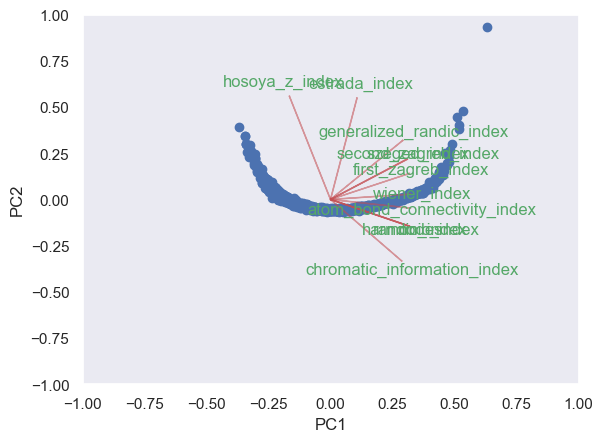

c:\Users\hoste\anaconda3\envs\pyg\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


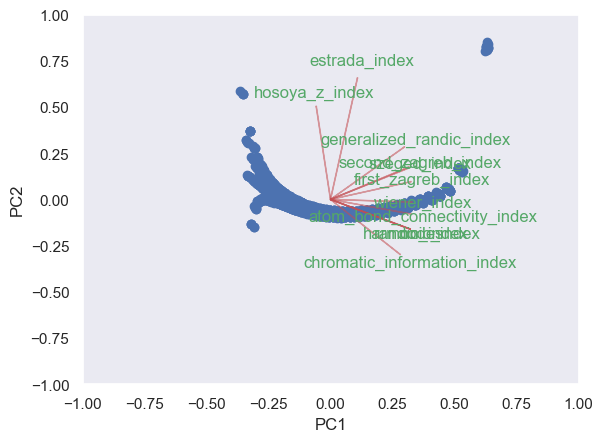

c:\Users\hoste\anaconda3\envs\pyg\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


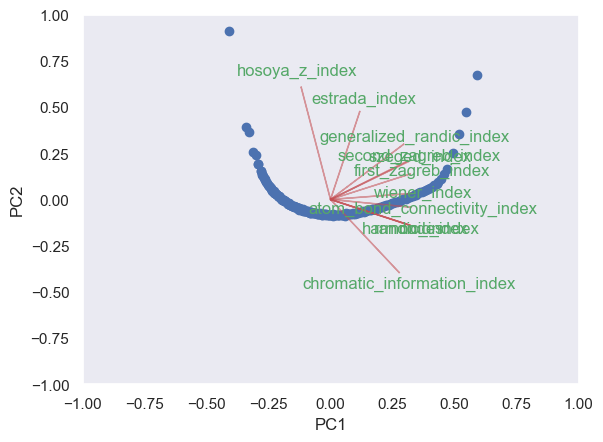

c:\Users\hoste\anaconda3\envs\pyg\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


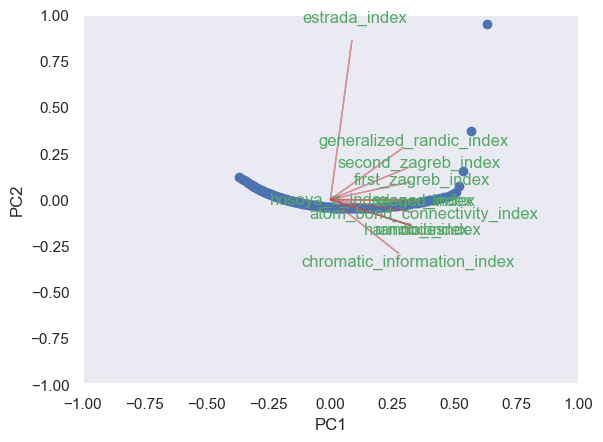

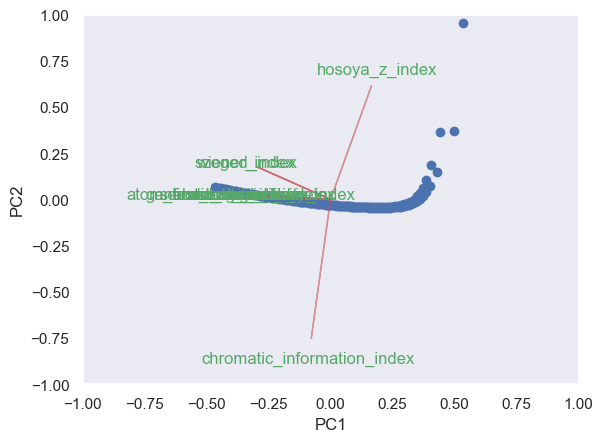

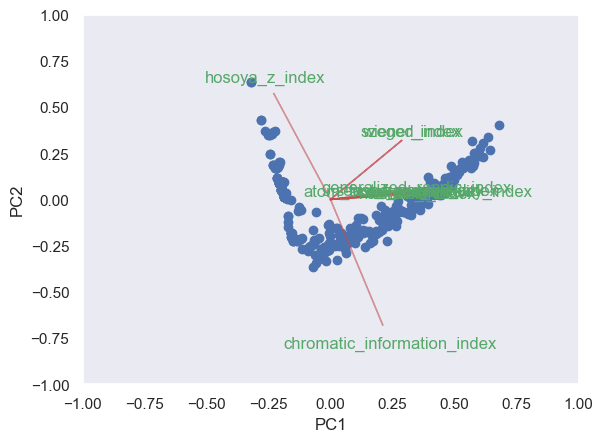

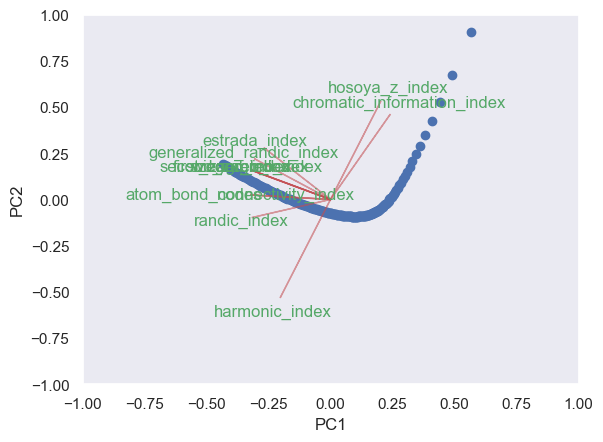

In [12]:
# In general, it's a good idea to scale the data prior to PCA.
from sklearn.preprocessing import StandardScaler

graph_ti_dict = next(iter(topological_indices_all_graphs["random"].values()))
feature_names = list(graph_ti_dict.keys())

for key in topological_indices_all_graphs.keys():
    numpy_arr = topo_numpy_array(topological_indices_all_graphs[key])
    data_scaled = pd.DataFrame(preprocessing.scale(
        numpy_arr), columns=feature_names)

    scaler = StandardScaler()
    scaler.fit(numpy_arr)
    X = scaler.transform(numpy_arr)
    pca = PCA()
    x_new = pca.fit_transform(X)

    def myplot(score, coeff, labels=None):
        xs = score[:, 0]
        ys = score[:, 1]
        n = coeff.shape[0]
        scalex = 1.0/(xs.max() - xs.min())
        scaley = 1.0/(ys.max() - ys.min())
        plt.scatter(xs * scalex, ys * scaley, c=None)
        for i in range(n):
            plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5)
            if labels is None:
                plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15,
                         feature_names[i], color='g', ha='center', va='center')
            else:
                plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15,
                         labels[i], color='g', ha='center', va='center')
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.xlabel("PC{}".format(1))
        plt.ylabel("PC{}".format(2))
        # plt.savefig(f"./docs/images/30_results/{key}-pca-loadings.png")
        plt.grid()

    # Call the function. Use only the 2 PCs.
    myplot(x_new[:, 0:2], np.transpose(pca.components_[0:2, :]))
    plt.show()


c:\Users\hoste\anaconda3\envs\pyg\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


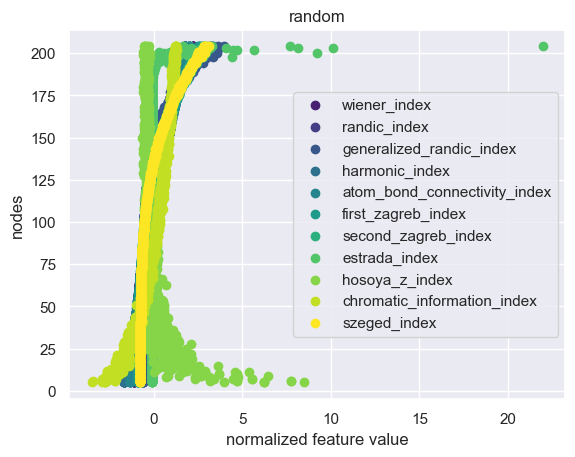

c:\Users\hoste\anaconda3\envs\pyg\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


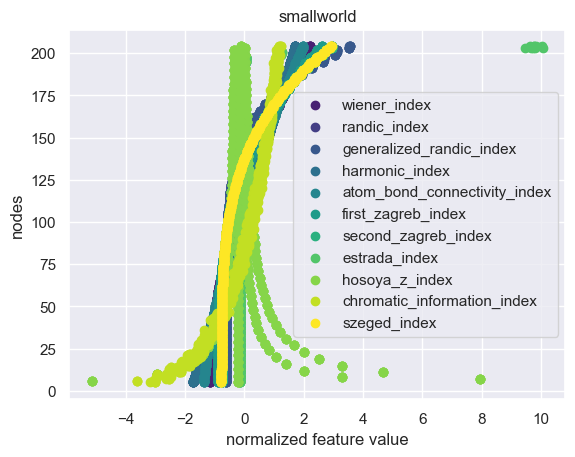

c:\Users\hoste\anaconda3\envs\pyg\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


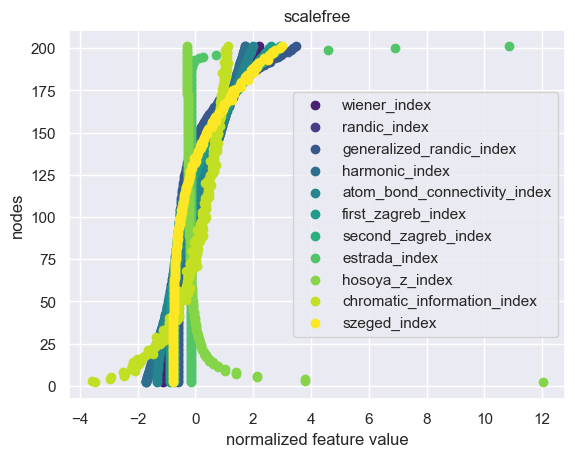

c:\Users\hoste\anaconda3\envs\pyg\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


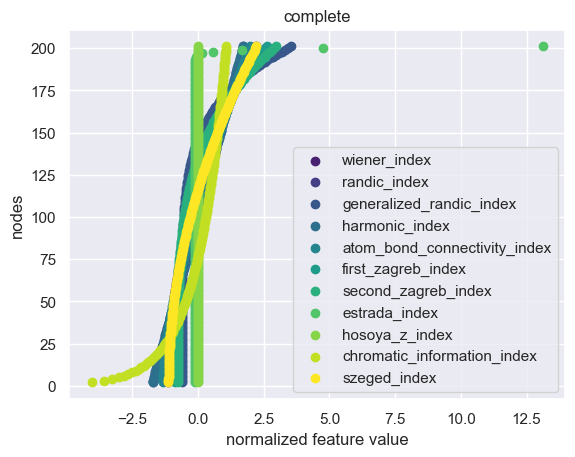

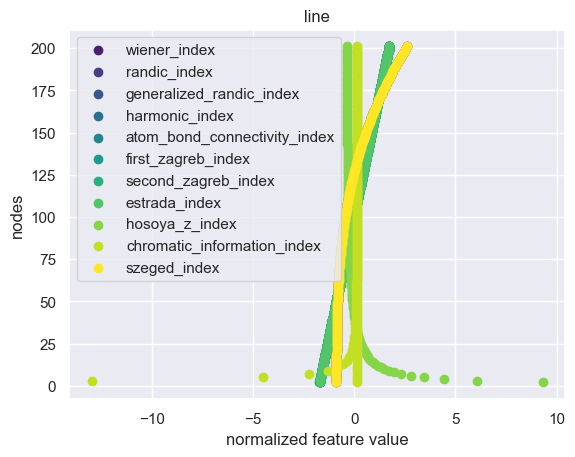

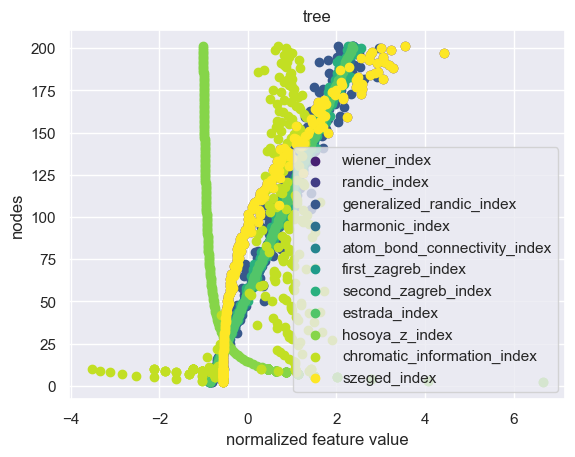

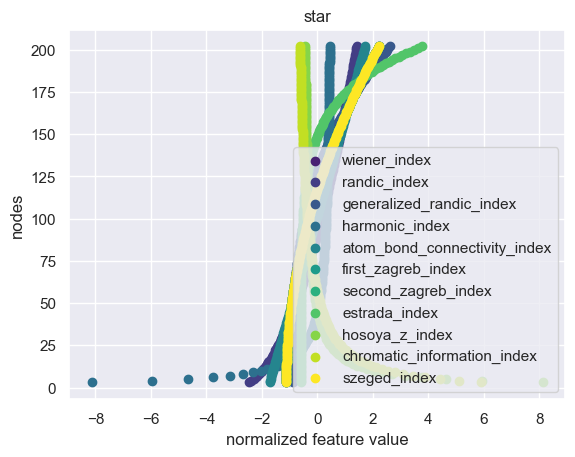

In [13]:
# visualize the scaled features in 2D in an all in one scatterplot

from matplotlib.axes._axes import _log as matplotlib_axes_logger
import matplotlib.pyplot as plt
matplotlib_axes_logger.setLevel('ERROR')

graph_ti_dict = next(iter(topological_indices_all_graphs["random"].values()))
feature_names = list(graph_ti_dict.keys())
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(feature_names)))


for key in topological_indices_all_graphs.keys():
    numpy_arr = topo_numpy_array(topological_indices_all_graphs[key])

    data_unscaled = pd.DataFrame(numpy_arr, columns=feature_names)
    # normalize data
    data_scaled = pd.DataFrame(preprocessing.scale(
        numpy_arr), columns=feature_names)

    pca_2c = pca_dataset(data_scaled, 2)

    fig, ax = plt.subplots()
    for i, (feature, color) in enumerate(zip(feature_names, colors), 1):
        if feature == "nodes":
            continue

        ax.scatter(y=data_unscaled['nodes'],
                   x=data_scaled[feature], label=feature, c=color)
        ax.set_ylabel('nodes')
        ax.set_xlabel('normalized feature value')

    plt.title(key)
    ax.legend()
    ax.grid(True)

    plt.show()


In [14]:
# now all we need to do is get the most influential feature for each class
graph_ti_dict = next(iter(topological_indices_all_graphs["random"].values()))
feature_names = list(graph_ti_dict.keys())
useful_topological_indices = {}

for key in topological_indices_all_graphs.keys():
    topological_indices_all_graphs[key]
    numpy_arr = topo_numpy_array(topological_indices_all_graphs[key])

    # normalize data
    data_scaled = pd.DataFrame(preprocessing.scale(
        numpy_arr), columns=feature_names)
    data_scaled.drop('nodes', axis=1, inplace=True)
    feature_names_without_nodes = feature_names.copy()
    feature_names_without_nodes.remove('nodes')

    pca_4c = pca_dataset(data_scaled, 4)

    n_pcs = pca_4c.components_.shape[0]
    most_important = [np.abs(pca_4c.components_[i]).argmax()
                      for i in range(n_pcs)]
    most_important_names = [
        feature_names_without_nodes[most_important[i]] for i in range(n_pcs)]
    dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
    df = pd.DataFrame(dic.items())

    print(
        f"------------ Most Important Features for PC(0-4) for class {key} ------------")
    print(df.head())

    useful_topological_indices[key] = most_important_names

# save the most important features for each class
with open('data/useful_topological_indices.pickle', 'wb') as f:
    pickle.dump(useful_topological_indices, f)


------------ Most Important Features for PC(0-4) for class random ------------
     0               1
0  PC0    wiener_index
1  PC1  hosoya_z_index
2  PC2   estrada_index
3  PC3  hosoya_z_index
------------ Most Important Features for PC(0-4) for class smallworld ------------
     0                            1
0  PC0                 wiener_index
1  PC1                estrada_index
2  PC2               hosoya_z_index
3  PC3  chromatic_information_index
------------ Most Important Features for PC(0-4) for class scalefree ------------
     0               1
0  PC0    wiener_index
1  PC1  hosoya_z_index
2  PC2   estrada_index
3  PC3  hosoya_z_index
------------ Most Important Features for PC(0-4) for class complete ------------
     0                            1
0  PC0                 wiener_index
1  PC1                estrada_index
2  PC2  chromatic_information_index
3  PC3  chromatic_information_index
------------ Most Important Features for PC(0-4) for class line ------------
     0  

c:\Users\hoste\anaconda3\envs\pyg\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\hoste\anaconda3\envs\pyg\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\hoste\anaconda3\envs\pyg\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\hoste\anaconda3\envs\pyg\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and 